# Кластеризация изображений

Для векторизации картинок с помощью CLIP и дальнейшей кластеризации будем использовать библиотеку [SentenceTransformers](https://www.sbert.net).

В качестве набора данных для кластеризации будем использовать датасет [Unsplash Dataset Lite](https://unsplash.com/data), который содержит 25000 изображений.

Мы переводим все изображения в векторное пространство, а затем находим области высокой плотности в этом векторном пространстве, то есть области, где изображения довольно сильно похожи друг на друга.

In [ ]:
%pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
import torch.nn.functional as F

#Загружаем модель (полный список можно посмотреть тут https://huggingface.co/sentence-transformers)
model = SentenceTransformer('clip-ViT-B-32')

In [ ]:
# Далее, скачиваем 25 тыс. изображений с Unsplash
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   # Скачиваем набор данных, если он не существует
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)

    # Извлекаем все изображения
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Извлечение'):
            zf.extract(member, img_folder)

In [4]:
# Получаем эмбеддинги картинок

img_names = list(glob.glob('photos/*.jpg'))
print("Images:", len(img_names))
img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Images: 24996


Batches: 100%|██████████| 196/196 [07:12<00:00,  2.21s/it]


<div style="width: 100%; background: #eeeeff; padding: 20px">
<h2>Архитектура модели</h2>
<p>Посмотрим на архитектуру визуальной модели</p>
</div>

In [5]:
print('Visual model\n\n', model[0].model.vision_model)
print('\n')
print('Visual projection\n\n', model[0].model.visual_projection)

Visual model

 CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (position_embedding): Embedding(50, 768)
  )
  (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias

<div style="width: 100%; background: #eeeeff; padding: 20px">
<h2>Эмбеддинги</h2>
<p>Выведем размер и пример эмбеддинга</p>
</div>

In [6]:
# Размер эмбеддинга
print('Размер эмбеддинга:', img_emb[0].shape)

Размер эмбеддинга: torch.Size([512])


In [7]:
print('Пример эмбеддинга:', img_emb[0][0:10])

Пример эмбеддинга: tensor([ 0.3907,  0.0633,  0.1086,  0.1621,  0.2564, -0.2214,  0.3498,  0.3413,
         0.4592,  0.1680], device='cuda:0')


In [8]:
print('Моменты:', img_emb.mean(), img_emb.var())

Моменты: tensor(-0.0266, device='cuda:0') tensor(0.2436, device='cuda:0')


<div style="width: 100%; background: #eeeeff; padding: 5px 20px">
<h2>Кластеризация</h2>
<p>Объявим функции кластеризации на основе косинусного расстояния между тензорами</p>
</div>

In [9]:
def cos_sim(a, b):
    """
    Косинусное расстояние между двумя тензорами

    A * B / (|A| * |B|)
    """
    dot_product = torch.dot(a, b)
    similarity = dot_product / (torch.norm(a) * torch.norm(b))
    return similarity

<div style="width: 100%; background: #eeeeff; padding: 20px">
<p>Поэлементно косинусные расстояния считать очень долго (на порядки), поэтому считаем их перемножая сразу все эмбеддинги с рассматриваемым (предварительно нормализовав их)</p>
</div>

In [10]:
def cos_sim_batch(idx, batch):
    """
    Косинусное расстояние для idx тензора по всему батчу
    """
    batch_normalized = F.normalize(batch, p=2, dim=1)
    return batch_normalized[idx : idx + 1] @ batch_normalized.T

<div style="width: 100%; background: #eeeeff; padding: 20px">
<p>Алгоритм следующий</p>
    <ol>
        <li>Для каждого эмбеддинга считаем косинусное расстояние до соседей. Убираем те, что меньше порога. Если их достаточное количество - сохраняем этот  список.</li>
        <li>Идем по полученному набору списков-кластеров и оставляем в них только уникальные значения. Далем это через алгебру множеств.</li>
        <li>Возвращаем уникальные наборы достаточного размера</li>
    </ol>
</div>

In [11]:
# Функция расчета косинусного расстояния и создания кластеров

def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Функция для быстрого обнаружения кластеров.

    Возвращает только те кластеры, которые больше, чем min_community_size. Кластеры возвращаются
    в порядке убывания. Первый элемент в каждом кластере - центральная точка кластера.
    """

    communities = []
    
    for i in tqdm(range(0, len(embeddings))):
        
        # Вычисляем оценки косинусной схожести (посмотрите на функцию cos_sim из util)
        #cos_scores = torch.tensor([cos_sim(embeddings[i], embeddings[j]) for j in range(len(embeddings))]) #SLOW
        cos_scores = cos_sim_batch(i, embeddings)[0].tolist() # FAST
        
        # Фильтрация  с значениями >= min_threshold
        cos_scores_over_threshold = list(map(lambda x: cos_scores.index(x), filter(lambda x: x > threshold, cos_scores)));
        
        # Минимальный размер кластера
        if len(cos_scores_over_threshold) < min_community_size:
            continue

        communities.append(cos_scores_over_threshold)

    # Сортируем по размеру кластера
    communities = sorted(communities, key=lambda x: len(x), reverse=True)

    # Оставляем только кластеры с уникальными наборами элементов
    unique_communities = []
    
    all_communities_set = set()
    for community in communities:
        community_set = set(community).difference(all_communities_set)
        if len(community_set) >= min_community_size:
            unique_communities.append(sorted(list(community_set)))
        all_communities_set.update(community_set)
    
    unique_communities = sorted(unique_communities, key=lambda x: len(x), reverse=True)

    return unique_communities

In [12]:
# Теперь запускаем алгоритм кластеризации
# С параметром threshold мы определяем, при каком пороге мы идентифицируем
# два изображения как похожие. Установите порог ниже, и вы получите более крупные кластеры, в которых
# изображения менее похожи.
# С параметром min_community_size мы определяем, что мы хотим иметь только кластеры определенного минимального размера

clusters = community_detection(img_emb, 0.9)
print("Общее количество кластеров:", len(clusters))

100%|██████████| 24996/24996 [02:44<00:00, 151.55it/s]


Общее количество кластеров: 236


In [14]:
# Выводим размеры 10 самых крупных кластеров
print('Размеры наибольших кластеров:', ', '.join([str(len(c)) for c in clusters[:10]]))

Размеры наибольших кластеров: 513, 412, 373, 292, 287, 160, 147, 135, 120, 116


<div style="width: 100%; background: #eeeeff; padding: 5px 20px">
<h2>Визуализация</h2>
<p>Выведем примеры изображений</p>
</div>

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(names, title):
    num = len(names)
    images = [mpimg.imread(name) for name in names]

    fig = plt.figure(figsize=(6, 2))
    fig.suptitle(title)
    
    for i in range(num):
        plt.subplot(100 + num * 10 + i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()

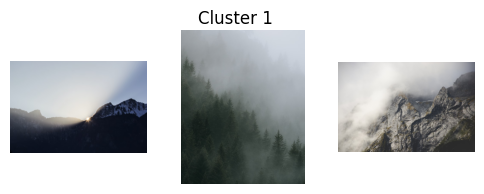

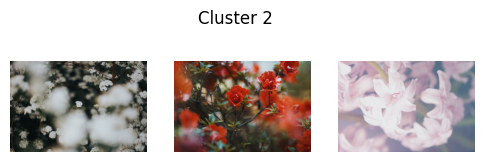

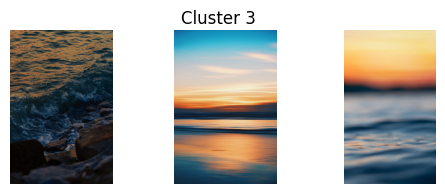

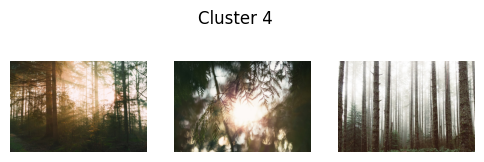

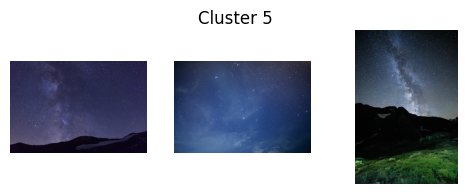

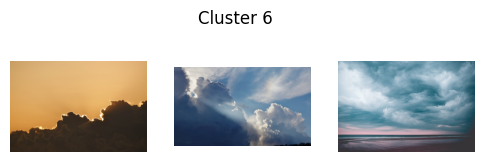

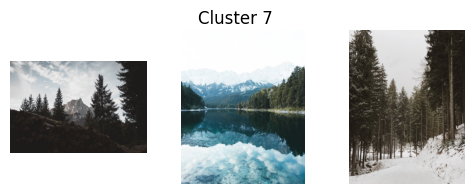

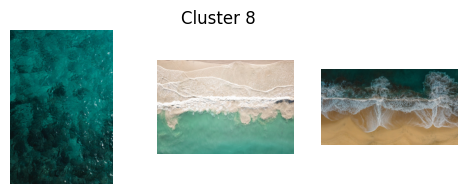

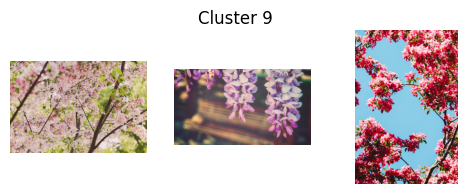

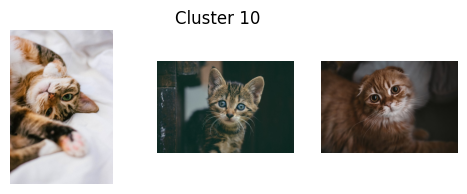

In [16]:
# Выводим по 3 картинки каждого кластера
for i in range(10):
    names = [img_names[c_i] for c_i in clusters[i][0:3]]
    show_images(names, f'Cluster {i + 1}')

<div style="width: 100%; background: #eeeeff; padding: 20px">
<p>Визуализируем некоторые примеры кластеризации в подпространствах эмбеддингов</p>
</div>

In [39]:
def get_cluster(i):
    filtered = list(filter(lambda c: i in c, clusters))
    if len(filtered) == 0:
        return -1
    return clusters.index(filtered[0])
        
def show_clusters():
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    
    for emb_i in range(4):
        for emb_j in range(4):
            x, y, targets = [], [], []
            for i in range(len(img_emb)):
                target = get_cluster(i)
                if target >= 0 and target < 2:
                    targets.append(target)
                    x.append(img_emb[i][emb_i].item())
                    y.append(img_emb[i][100 + emb_j].item())
            axs[emb_i, emb_j].scatter(x, y, c=targets)

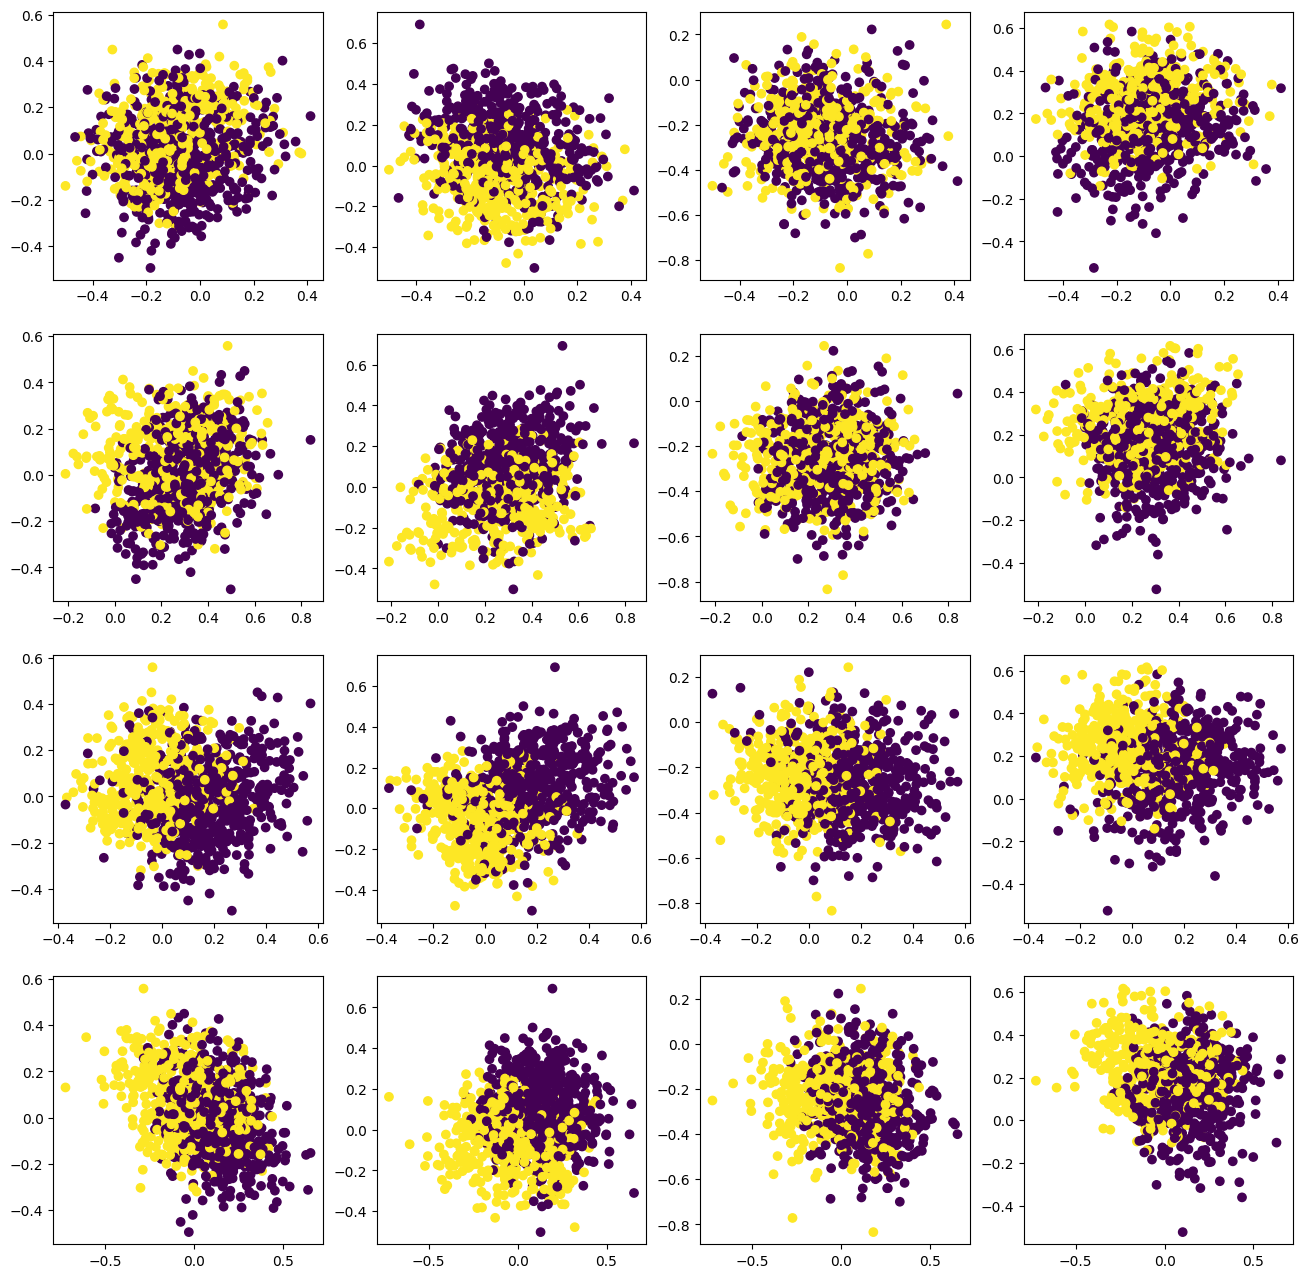

In [40]:
show_clusters()